<a href="https://colab.research.google.com/github/woncoh1/TSAI/blob/main/END2/S5/END2S5A_SST_Multiclass_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

- Look at [this code](https://colab.research.google.com/drive/19wZi7P0Tzq9ZxeMz5EDmzfWFBLFWe6kN?usp=sharing&pli=1&authuser=0) above. It has additional details on "Back Translate", i.e. using Google translate to convert the sentences. It has "random_swap" function, as well as "random_delete". 

- Use "Back Translate", "random_swap" and "random_delete" to augment the data you are training on

- Download the StanfordSentimentAnalysis Dataset from [this link](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip)(it might be troubling to download it, so force download on chrome). Use "**datasetSentences.txt**" and "**sentiment_labels.txt**" files from the zip you just downloaded as your dataset. This dataset contains just over 10,000 pieces of Stanford data from HTML files of Rotten Tomatoes. The sentiments are rated between 1 and 25, where one is the most negative and 25 is the most positive.

- Train your model and achieve **60%+ validation/test accuracy**. Upload your collab file on GitHub with readme that contains details about your assignment/word (minimum **250 words**), **training logs showing final validation accuracy, and outcomes for 10 example inputs from the test/validation data**.

- **You must submit before DUE date (and not "until" date)**.

# 0. Setup

In [1]:
!python --version

Python 3.7.10


## 0-1 Install Packages

In [2]:
!pip install google_trans_new

## 0-2 Import Modules

In [3]:
import random

import pandas as pd
import seaborn as sns

import torch
from torchtext.legacy import data

from typing import Generator, NamedTuple
import functools

from joblib import Parallel, delayed 

# 2. Augment Dataset
import google_trans_new
from google_trans_new import google_translator

from toolz.functoolz import pipe
from tqdm.notebook import tqdm
import pickle

# 4-1 Define Model
import torch.nn as nn
import torch.nn.functional as F

# 5-1 Instantiate Optimizer
import torch.optim as optim

# 6-3 Test with User Input
import spacy

## 0-3 Define Hyperparameters

In [4]:
# 3-3 Split Datasets
SPLIT_RATIO = [0.6, 0.2, 0.2]

# 3-5 Create Batches
BATCH_SIZE = 64

# 2. Augment Data
BACK_TRANSLATION_PROBABILITY = 0.1
DELETION_PROBABILITY = 0.1
SWAP_COUNT = 1

# 3-4 Build Vocabulary
MAX_VOCAB_SIZE = 15_000
TOKENIZER = 'spacy'
TOKENIZER_LANGUAGE = 'en_core_web_sm'

# 2-2 Instantiate Model
EMBEDDING_DIM = 100
NUM_HIDDEN_NODES = 200
NUM_OUTPUT_NODES = 5
NUM_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.4

# 3-5 Train Epochs
EPOCHS = 20

## 0-4 Ensure Reproducibility

In [5]:
SEED = 43
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## 0-5 Set Device

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 0-6 Set Options

In [7]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html
pd.set_option("min_rows", 20)
pd.set_option("max_colwidth", 100)

# https://pytorch.org/docs/stable/generated/torch.set_printoptions.html
# torch.set_printoptions(threshold=20000000, linewidth=200)

# 1. Explore Data

## 1-1 Download Data

In [8]:
!wget -O stanford_sentiment_treebank.zip https://drive.google.com/u/0/uc?id=1rQc_TQvAnGQ8zyQ8IIaTjsZbIcveDac0&export=download
#!wget -O stanford_sentiment_treebank.zip http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip

--2021-06-03 13:50:24--  https://drive.google.com/u/0/uc?id=1rQc_TQvAnGQ8zyQ8IIaTjsZbIcveDac0
Resolving drive.google.com (drive.google.com)... 74.125.133.100, 74.125.133.139, 74.125.133.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.133.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1h8j1tb0l0nje51tkn4t36u7bpgl3get/1622728200000/15551131083655977576/*/1rQc_TQvAnGQ8zyQ8IIaTjsZbIcveDac0 [following]
--2021-06-03 13:50:32--  https://doc-0s-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1h8j1tb0l0nje51tkn4t36u7bpgl3get/1622728200000/15551131083655977576/*/1rQc_TQvAnGQ8zyQ8IIaTjsZbIcveDac0
Resolving doc-0s-2o-docs.googleusercontent.com (doc-0s-2o-docs.googleusercontent.com)... 108.177.15.132, 2a00:1450:400c:c0c::84
Connecting to doc-0s-2o-docs.googleusercontent.com (doc-0s-2o-docs.googleusercontent.com)|10

In [9]:
!unzip stanford_sentiment_treebank.zip

Archive:  stanford_sentiment_treebank.zip
   creating: stanfordSentimentTreebank/
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
   creating: __MACOSX/
   creating: __MACOSX/stanfordSentimentTreebank/
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: __MACOSX/stanfordSentimentTreebank/._sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stan

## 1-2 Inspect README

After inspecting the README file for our dataset, we notice the following caveats:

1. `sentiment_labels.txt` contains sentiment values for **phrases**, not **sentences**.

    - But **phrases** contain **full sentences** as well as **non-sentence phrases**!
    - This is because the Stanford Sentiment Treebank dataset is a tree with leaves as word tokens and internal nodes as sentiments of the phrases, which are represented by sub-trees with each internal node as the root node.

2. `datasetSentences.txt` contains only full sentences **without** any sentiment values.
    - We need to recover the sentiment values and sentiment classes for each sentence.

3. `datasetSplit.txt` contains set labels 1 (train) and 2 (test) only without any 3s (dev/valid). 
    - We need to manually split the dataset for a validation set.

## 1-3 Load Data

In [10]:
dataset_sentences = pd.read_csv('stanfordSentimentTreebank/datasetSentences.txt', 
                                sep='\t')
sentiment_labels = pd.read_csv('stanfordSentimentTreebank/sentiment_labels.txt', 
                               sep='|',
                               names=['phrase_id', 'sentiment_value'],
                               header=0)                
phrase_dictionary = pd.read_csv('stanfordSentimentTreebank/dictionary.txt', 
                              sep='|', 
                              names=['phrase_text', 'phrase_id'])

## 1-4 Inspect Data

In [11]:
dataset_sentences

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a sp...
1,2,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a c...
2,3,Effective but too-tepid biopic
3,4,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start ."
4,5,"Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n'..."
5,6,The film provides some great insight into the neurotic mindset of all comics -- even those who h...
6,7,Offers that rare combination of entertainment and education .
7,8,Perhaps no picture ever made has more literally showed that the road to hell is paved with good ...
8,9,Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it .
9,10,But he somehow pulls it off .


In [12]:
sentiment_labels

,phrase_id,sentiment_value
0,0,0.50000
1,1,0.50000
2,2,0.44444
3,3,0.50000
4,4,0.42708
5,5,0.37500
6,6,0.41667
7,7,0.54167
8,8,0.33333
9,9,0.45833


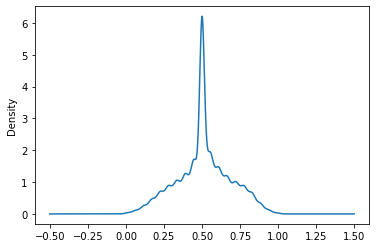

In [13]:
phrase_density = sentiment_labels.sentiment_value.plot.density()

In [14]:
phrase_dictionary

,phrase_text,phrase_id
0,!,0
1,! ',22935
2,! '',18235
3,! Alas,179257
4,! Brilliant,22936
5,! Brilliant !,40532
6,! Brilliant ! ',22937
7,! C'mon,60624
8,! Gollum 's ` performance ' is incredible,13402
9,"! Oh , look at that clever angle ! Wow , a jump cut !",179258


In [15]:
sentiment_labels = sentiment_labels.set_index('phrase_id')
phrase_dictionary = phrase_dictionary.set_index('phrase_id')

In [16]:
sentiment_labels

,sentiment_value
phrase_id,
0,0.50000
1,0.50000
2,0.44444
3,0.50000
4,0.42708
5,0.37500
6,0.41667
7,0.54167
8,0.33333


In [17]:
phrase_dictionary

,phrase_text
phrase_id,
0,!
22935,! '
18235,! ''
179257,! Alas
22936,! Brilliant
40532,! Brilliant !
22937,! Brilliant ! '
60624,! C'mon
13402,! Gollum 's ` performance ' is incredible


## 1-5 Join Text and Label

In [18]:
sentiment_examples = phrase_dictionary.join(sentiment_labels).sort_index().reset_index()
sentiment_examples = sentiment_examples.rename(
    columns= {
        'phrase_text': 'text',
        'sentiment_value': 'label',
        'phrase_id' : 'id',
})
sentiment_examples = sentiment_examples.set_index('id')
sentiment_examples

,text,label
id,,
0,!,0.50000
1,',0.50000
2,' (,0.44444
3,' ( the cockettes,0.50000
4,' ( the cockettes ),0.42708
5,' ( the cockettes ) provides a window into a subculture hell-bent on expressing itself in every ...,0.37500
6,' ( the cockettes ) provides a window into a subculture hell-bent on expressing itself in every ...,0.41667
7,' ( the cockettes ) provides a window into a subculture hell-bent on expressing itself in every ...,0.54167
8,' a nightmare on elm street,0.33333


## 1-6 Recover Label Class

In [19]:
def recover_class(sentiment_value: "positivity probability") -> str:
    if sentiment_value < 0:
        raise ValueError("Sentiment value should be greater than 0.")
    elif sentiment_value <= 0.2:
        return "very negative"
    elif sentiment_value <= 0.4:
        return "negative"
    elif sentiment_value <= 0.6:
        return "neutral"
    elif sentiment_value <= 0.8:
        return "positive"
    elif sentiment_value <= 1.0:
        return "very positive"
    else:
        raise ValueError("Sentiment value should be less than 1.") 

In [20]:
sentiment_examples.label = sentiment_examples.label.apply(recover_class)
sentiment_examples

,text,label
id,,
0,!,neutral
1,',neutral
2,' (,neutral
3,' ( the cockettes,neutral
4,' ( the cockettes ),neutral
5,' ( the cockettes ) provides a window into a subculture hell-bent on expressing itself in every ...,negative
6,' ( the cockettes ) provides a window into a subculture hell-bent on expressing itself in every ...,neutral
7,' ( the cockettes ) provides a window into a subculture hell-bent on expressing itself in every ...,neutral
8,' a nightmare on elm street,negative


In [21]:
def plot_label(data: pd.DataFrame):
    plot = sns.countplot(
        x='label',
        data=data,
        order=['very negative', 
               'negative',
               'neutral', 
               'positive', 
               'very positive'], 
        palette='viridis',
    )
    plot 

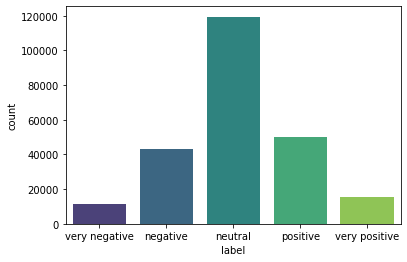

In [22]:
plot_label(sentiment_examples)

## 1-7 Select Full Sentences

In [23]:
sentence_sentiments = pd.merge(dataset_sentences, sentiment_examples,
                               left_on='sentence',right_on='text')
sentence_sentiments = sentence_sentiments[['label', 'text']]
sentence_sentiments

,label,text
0,positive,The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a sp...
1,very positive,The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a c...
2,neutral,Effective but too-tepid biopic
3,positive,"If you sometimes like to go to the movies to have fun , Wasabi is a good place to start ."
4,very positive,"Emerges as something rare , an issue movie that 's so honest and keenly observed that it does n'..."
5,neutral,The film provides some great insight into the neurotic mindset of all comics -- even those who h...
6,very positive,Offers that rare combination of entertainment and education .
7,positive,Perhaps no picture ever made has more literally showed that the road to hell is paved with good ...
8,positive,Steers turns in a snappy screenplay that curls at the edges ; it 's so clever you want to hate it .
9,positive,But he somehow pulls it off .


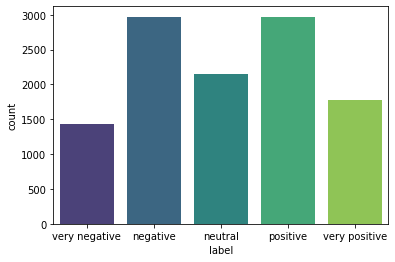

In [24]:
plot_label(sentence_sentiments)

# 2. Augment Data

In [25]:
DatasetIterator = Generator[NamedTuple, None, None]

def generate_iterator(dataset: pd.DataFrame) -> DatasetIterator:
    yield from dataset.itertuples(index=False, name='Example')

In [26]:
def convert_list_to_dataframe(texts: list) -> pd.DataFrame:
    df = pd.DataFrame(columns=['label', 'text'])
    for label, text in texts:
        df = df.append({'label': label, 'text': text}, 
                       ignore_index=True)
    return df

## 2-1 Back Translation

- Translate a sentence to a random language, and then translate back to the 
original language.

In [27]:
GoogleTranslator = google_trans_new.google_trans_new.google_translator

def back_translate(example: NamedTuple, 
                   translator: GoogleTranslator, 
                   availables: list) -> str:
    # choose random language
    trans_lang = random.choice(availables) 
    #print(f"Translating to {google_trans_new.LANGUAGES[trans_lang]}")

    # translate to the target language
    translation = translator.translate(example.text,
                                        lang_src='en',
                                        lang_tgt=trans_lang) 

    # translate back to original language
    back_translation = translator.translate(translation, 
                                            lang_src=trans_lang, 
                                            lang_tgt='en') 

    # select only one translation
    if isinstance(back_translation, list):
        back_translation = back_translation[0]
    
    return example.label, back_translation

In [28]:
def apply_back_translation(dataset:pd.DataFrame,
                           p: float = BACK_TRANSLATION_PROBABILITY) -> pd.DataFrame:
    translator = google_translator()
    availables = list(google_trans_new.LANGUAGES.keys()) 
    progress_bar = tqdm(generate_iterator(dataset), total=len(dataset.index))

    back_translations = Parallel(n_jobs=-1, prefer="threads")(
        delayed(back_translate)(example, translator, availables)
        for example in progress_bar 
        if random.uniform(0, 1) < p
    )

    back_translations = convert_list_to_dataframe(back_translations)

    return back_translations

## 2-2 Random Deletion

- Randomly delete words from a sentence with a given probability.


In [29]:
def random_delete(example: NamedTuple, 
                  p: float = DELETION_PROBABILITY): 
    sentence = example.text.split(' ')
    # return if single word
    if len(sentence) == 1: 
        return example.label, sentence
    # delete words
    remaining = list(filter(lambda x: random.uniform(0, 1) > p, sentence)) 
    # if nothing left, sample a random word
    if len(remaining) == 0: 
        return example.label, [random.choice(sentence)] 
    else:
        return example.label, ' '.join(remaining)

In [30]:
def apply_random_deletion(dataset:pd.DataFrame) -> pd.DataFrame:
    map_delete = functools.partial(map, random_delete)
    random_deletions = pipe(
        dataset,
        generate_iterator,
        map_delete,
        list,
        convert_list_to_dataframe
    )
    return random_deletions

## 2-3 Random Swap
- Randomly swap a pair of words in a sentence for a given no. of times.

In [31]:
def random_swap(example: NamedTuple, 
                n: int = SWAP_COUNT): 
    sentence = example.text.split(' ')
    if len(sentence) < 2:
      return example.label, sentence
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(sentence)), 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return example.label, ' '.join(sentence)

In [32]:
def apply_random_swap(dataset:pd.DataFrame) -> pd.DataFrame:
    map_swap = functools.partial(map, random_swap)
    random_swaps = pipe(
        dataset,
        generate_iterator,
        map_swap,
        list,
        convert_list_to_dataframe
    )
    return random_swaps

## 2-4 Apply Augmentations

In [33]:
augmented_dataset = pd.concat([
                               sentence_sentiments,
                               apply_back_translation(sentence_sentiments),
                               apply_random_deletion(sentence_sentiments), 
                               apply_random_swap(sentence_sentiments),
                               ]).reset_index(drop=True)

# 3. Prepare Torchtext Dataset

- Here we format datasets for model training using Torchtext-specific API from `torchtext.legacy.data`:

    - `Field`
        - `build_vocab`
        - `vocab`
    - `Example`
        - `fromlist`
    - `Dataset`
        - `split`
    -  `BucketIterator`

-  Since this Torchtext-specific API will be replaced by a new, general Pytorch API, we will refactor codes in this section [using this migration guide](https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb).

## 3-1 Define Fields

- Now we shall be defining `Label` as a LabelField, which is a subclass of Field that sets sequential to False (as it’s our numerical category class).

- `Text` is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐case.

In [34]:
Text = data.Field(
    sequential=True,
    tokenize=TOKENIZER, 
    tokenizer_language = TOKENIZER_LANGUAGE,
    include_lengths=True,
)

Label = data.LabelField(
    sequential=False,
    tokenize=TOKENIZER, 
    is_target=True, 
)

- Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [35]:
fields = [('text', Text), ('label', Label)]

- Armed with our declared fields, lets convert from pandas to list to torchtext.

- We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

## 3-2 Create Dataset

In [36]:
examples = Parallel(n_jobs=-1, prefer="threads")(
        delayed(data.Example.fromlist)([augmented_dataset.text[i],
                                        augmented_dataset.label[i]], 
                                       fields)
        for i in tqdm(range(augmented_dataset.shape[0]))
)

In [37]:
unsplit_dataset = data.Dataset(examples, fields)

## 3-3 Split Datasets

- Finally, we can split into training, testing, and validation sets by using the `split()` method:

In [38]:
(train, valid, test) = unsplit_dataset.split(split_ratio=SPLIT_RATIO, 
                                             random_state=random.seed(SEED))

In [39]:
(len(train), len(valid), len(test))

(20983, 6995, 6994)

- An example from the dataset:

In [40]:
vars(train.examples[10])

{'label': 'very positive',
 'text': ['One',
  'of',
  'the',
  'most',
  'movies',
  'exquisite',
  'anti',
  '-',
  'adult',
  'slyly',
  'ever',
  'made',
  '.']}

## 3-4 Build Vocabulary

- At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process.

- Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabulary to the most common words. 

- This is normally done to prevent the construction of a huge, memory-hungry model. 

- We don’t want our GPUs too overwhelmed, after all. 

- Let’s limit the vocabulary to a maximum of 10,000 words in our training set:


In [ ]:
Text.build_vocab(
    train, 
    max_size = MAX_VOCAB_SIZE,
    vectors = "glove.6B.100d", # use pre-trained embeddings
    unk_init = torch.Tensor.normal_ # randomly initialize out-of-vocab words
)

Label.build_vocab(train)

- By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

### Inspect Vocabulary

In [ ]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', dict(Label.vocab.stoi))

- **↑ Lots of stopwords!**

### Save Vocabulary

- Save for later use during prediction/inference with user inputs.

In [ ]:
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

## 3-5 Create Batches

- Now we need to create a data loader to feed into our training loop. 

- Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

- Here we send all dataset iterators to GPU (if available).

In [ ]:
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train, valid, test), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True, 
    device = device)

# 4. Build Model

## 4-1 Define Model

In [ ]:
class Sentimentalist(nn.Module):
    
    # parts list
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 num_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()          
        
        # embedding: initialized with pre-trained word embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim, 
                                      padding_idx = pad_idx)
        
        # encoder: GRU
        self.encoder = nn.GRU(embedding_dim, hidden_dim, 
                              num_layers=num_layers,
                              bidirectional=bidirectional,
                              dropout=dropout)
        
        # decoder: fully connected layer
        self.decoder = nn.Linear(hidden_dim * 2, output_dim)

        # dropout for every layer
        self.dropout = nn.Dropout(dropout)

    # assembly manual    
    def forward(self, text, text_lengths):
        
        # text = [batch size, sentence length]
        
        # embed: GLoVe
        embedded = self.dropout(self.embedding(text))
        
        # embedded = [batch size, sentence length, embedding dimension]
      
        # pack sequence: so that last word is not <pad>
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths.cpu())
        
        # encode: GRU layers        
        packed_output, hidden = self.encoder(packed_embedded)
        
        # hidden = [batch size, no. of layers * no. of directions, hidden dimension]

        hidden = self.dropout(torch.cat((hidden[-2,:,:], 
                                         hidden[-1,:,:]), 
                                        dim = 1))
                
        #hidden = [batch size, hidden dimension * no. of directions]

        # decode: FC layer
        dense_output = self.decoder(hidden) # no dropout before softmax

        # dense_output = [batch size, no. of classes]

        # classify: final activation function (softmax) before loss function
        output = F.softmax(dense_output, dim=1)

        # output = [batch size, no. of classes]
            
        return output

## 4-2 Instantiate Model

In [ ]:
vocabulary_size = len(Text.vocab)
padding_index = Text.vocab.stoi[Text.pad_token]

model = Sentimentalist(vocabulary_size, EMBEDDING_DIM, NUM_HIDDEN_NODES, NUM_OUTPUT_NODES, 
                       num_layers=NUM_LAYERS, bidirectional=BIDIRECTIONAL, dropout=DROPOUT,
                       pad_idx=padding_index)

print(model)

In [ ]:
# No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

## 4-3 Modify Embedding Layer

### Copy Pre-trained Embeddings

In [ ]:
pretrained_embeddings = Text.vocab.vectors

print(pretrained_embeddings.shape)

In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

### Initialize Special-character Embeddings

In [ ]:
unknown_index = Text.vocab.stoi[Text.unk_token]

model.embedding.weight.data[unknown_index] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[padding_index] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

## 4-4 Instantiate Loss

In [ ]:
criterion = nn.CrossEntropyLoss()

## 4-5 Send Model and Loss to GPU

In [ ]:
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

# 5. Train (and Evaluate) Model

## 5-1 Instantiate Optimizer

In [ ]:
optimizer = optim.Adam(model.parameters())

## 5-2 Define Accuracy

In [ ]:
def binary_accuracy(preds, y):
    # round predictions to the closest integer
    _, predictions = torch.max(preds, dim=1)
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

## 5-3 Define Trainer

- The main thing to be aware of in this new training loop is that we have to reference `batch.text` and `batch.label` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model to training mode
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        text, text_lengths = batch.text
        
        # convert to 1D tensor
        predictions = model(text, text_lengths).squeeze(1)  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## 5-4 Define Evaluator

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # set model to evaluation mode (deactivate dropout layers)
    model.eval()
    
    # deactivate autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.text
            
            # convert to 1d tensor
            predictions = model(text, text_lengths).squeeze(1)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## 5-5 Train Epochs

In [ ]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # print results for each epoch
    print(f'Epoch: {epoch + 1}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

# 4. Test Model

In [ ]:
def classify_sentiment(text: str):
    
    # load saved weights
    path='./saved_weights.pt'
    model.load_state_dict(torch.load(path))
    model.eval()

    # load saved vocabulary
    tokenizer_file = open('./tokenizer.pkl', 'rb')
    tokenizer = pickle.load(tokenizer_file)

    # load English tokenizer 
    nlp = spacy.load(TOKENIZER_LANGUAGE)
        
    # tokenize text 
    tokenized = [tok.text for tok in nlp.tokenizer(text)] 
    # numericalize text
    indexed = [tokenizer[t] for t in tokenized]        

    # convert text to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape tensor to [batch, no. of words]     
    tensor = tensor.unsqueeze(1) # .T if batch_first = True
    
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    
    # get model prediction                  
    prediction = model(tensor, length_tensor)
    _, pred = torch.max(prediction, dim=1) 
    
    # return sentiment class
    return Label.vocab.itos[pred.item()]

## 6-1 Test with Test Dataset

In [ ]:
# load best weights to model
model.load_state_dict(torch.load('saved_weights.pt'))

# evaluate best model on test dataset
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

## 6-2 Test with Individual Test Sample

In [ ]:
test_iterator = data.BucketIterator(
    test, 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch=True, 
    device = device)

## 6-3 Test with User Input

In [ ]:
classify_sentiment("Obama has called the GOP budget social Darwinism. Nice try, but they believe in social creationism.")

In [ ]:
classify_sentiment("A valid explanation for why Trump won't let women on the golf course.")

In [ ]:
classify_sentiment("In his teen years, Obama has been known to use marijuana and cocaine.")

In [ ]:
classify_sentiment("This film is terrible.")

In [ ]:
classify_sentiment("This film is okay.")

In [ ]:
classify_sentiment("This movie is interesting.")

In [ ]:
classify_sentiment("This film is extremely wonderful.")

# Reference

1. [Ben Trevett's Simple Pytorch Sentiment Analysis](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb)

2. [Ben Trevett's Upgraded Pytorch Sentiment Analysis](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb)

3. [Stanford Sentiment Treebank Paper](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

In [ ]:
# THE END